In [1]:
import nle.dataset as nld
from nle.nethack import tty_render
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

from nle.dataset import db

In [2]:
nld_nao_path = "/code/nld-nao/nld-nao-unzipped"

dbfilename = "/code/persistence/nld-nao.db"

dataset_name = "nld-nao"

In [3]:
if not nld.db.exists(dbfilename):
    nld.db.create(dbfilename)
    # Add NLD-NAO data, use the `add_altorg_directory`.
    nld.add_altorg_directory(nld_nao_path, "nld-nao", dbfilename)

In [4]:
db_conn = nld.db.connect(filename=dbfilename)
print(f"AltOrg Dataset has {nld.db.count_games('nld-nao', conn=db_conn)} games.")

AltOrg Dataset has 1511228 games.


In [28]:
def game_data(dbfilename):
    query = """
    SELECT name, gameid, points, turns, maxlvl, starttime, endtime, death
    FROM games
    ORDER BY name, starttime
    """
    with sqlite3.connect(dbfilename) as conn:
        data = pd.read_sql_query(query, conn)
    data['starttime'] = pd.to_datetime(data['starttime'])
    data['endtime'] = pd.to_datetime(data['endtime'])
    return data


data = game_data(dbfilename)
data

,name,gameid,points,turns,maxlvl,starttime,endtime,death
0,Player0,3520378,0,52,1,1970-01-01 00:00:01.206144424,1970-01-01 00:00:01.206144460,killed by kicking a wall
1,Player0,3520380,0,10,1,1970-01-01 00:00:01.206144463,1970-01-01 00:00:01.206144590,killed by kicking a wall
2,Player0,3520795,161,308,3,1970-01-01 00:00:01.206223951,1970-01-01 00:00:01.206224061,quit
3,Player0,3521208,250,8,6,1970-01-01 00:00:01.206271297,1970-01-01 00:00:01.206300939,killed by a priestess of Brigit
4,Player0,3521210,3,1,1,1970-01-01 00:00:01.206300990,1970-01-01 00:00:01.206301044,escaped (in celestial disgrace)
...,...,...,...,...,...,...,...,...
1511223,Player9999,2822112,19,124,1,1970-01-01 00:00:01.511176919,1970-01-01 00:00:01.514545971,quit
1511224,Player9999,2858553,90,592,2,1970-01-01 00:00:01.514545991,1970-01-01 00:00:01.517799208,killed by a magic missile
1511225,Player9999,2965129,0,68,1,1970-01-01 00:00:01.529984646,1970-01-01 00:00:01.529984769,quit
1511226,Player9999,2056247,0,11,1,1970-01-01 00:00:01.536897505,1970-01-01 00:00:01.536897540,escaped


In [21]:
# Calculate player statistics
player_stats = data.groupby('name').agg(
    total_games=('gameid', 'count'),
    avg_points=('points', 'mean'),
    max_points=('points', 'max'),
    avg_maxlvl=('maxlvl', 'mean'),
    max_maxlvl=('maxlvl', 'max'),
    avg_turns=('turns', 'mean')
).reset_index()

print(player_stats.describe())

        total_games    avg_points    max_points    avg_maxlvl    max_maxlvl  \
count  48077.000000  4.807700e+04  4.807700e+04  48077.000000  48077.000000   
mean      31.433492  7.802430e+04  1.136086e+06      4.261282     10.100880   
std      186.733419  3.633138e+06  3.496484e+07      4.309178     13.588667   
min        1.000000  0.000000e+00  0.000000e+00      0.800000      1.000000   
25%        1.000000  1.706667e+02  2.340000e+02      2.000000      2.000000   
50%        3.000000  6.760000e+02  1.408000e+03      3.333333      5.000000   
75%       12.000000  3.296261e+03  1.199700e+04      5.288889     10.000000   
max    16019.000000  5.327036e+08  4.239364e+09     53.000000     69.000000   

           avg_turns  
count   48077.000000  
mean     2432.093604  
std      6945.353827  
min         1.000000  
25%       533.291667  
50%      1204.750000  
75%      2485.500000  
max    891749.419355  


/tmp/ipykernel_8381/27587243.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  early_games = data.groupby('name').apply(lambda x: x.iloc[:len(x)//2]).reset_index(drop=True)
/tmp/ipykernel_8381/27587243.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  late_games = data.groupby('name').apply(lambda x: x.iloc[len(x)//2:]).reset_index(drop=True)


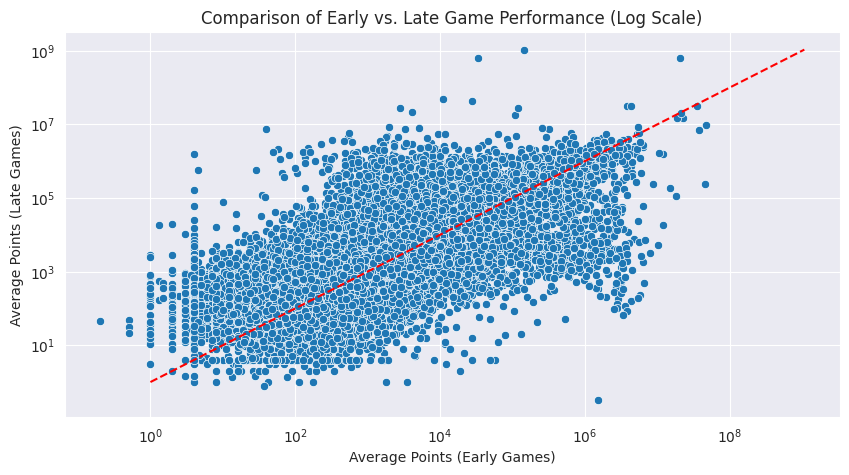

In [17]:
# Divide games into early and late
early_games = data.groupby('name').apply(lambda x: x.iloc[:len(x)//2]).reset_index(drop=True)
late_games = data.groupby('name').apply(lambda x: x.iloc[len(x)//2:]).reset_index(drop=True)

# Calculate average points for early and late games
early_avg_points = early_games.groupby('name')['points'].mean()
late_avg_points = late_games.groupby('name')['points'].mean()

plt.figure(figsize=(10, 5))
sns.scatterplot(x=early_avg_points, y=late_avg_points)
plt.xlabel('Average Points (Early Games)')
plt.ylabel('Average Points (Late Games)')
plt.title('Comparison of Early vs. Late Game Performance (Log Scale)')
plt.xscale('log')
plt.yscale('log')
plt.plot([1, max(late_avg_points.max(), early_avg_points.max())], 
         [1, max(late_avg_points.max(), early_avg_points.max())], 'r--')  # 45-degree line
plt.show()

/tmp/ipykernel_8381/2322457821.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  early_games = data.groupby('name').apply(lambda x: x.iloc[:len(x)//2]).reset_index(drop=True)
/tmp/ipykernel_8381/2322457821.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  late_games = data.groupby('name').apply(lambda x: x.iloc[len(x)//2:]).reset_index(drop=True)


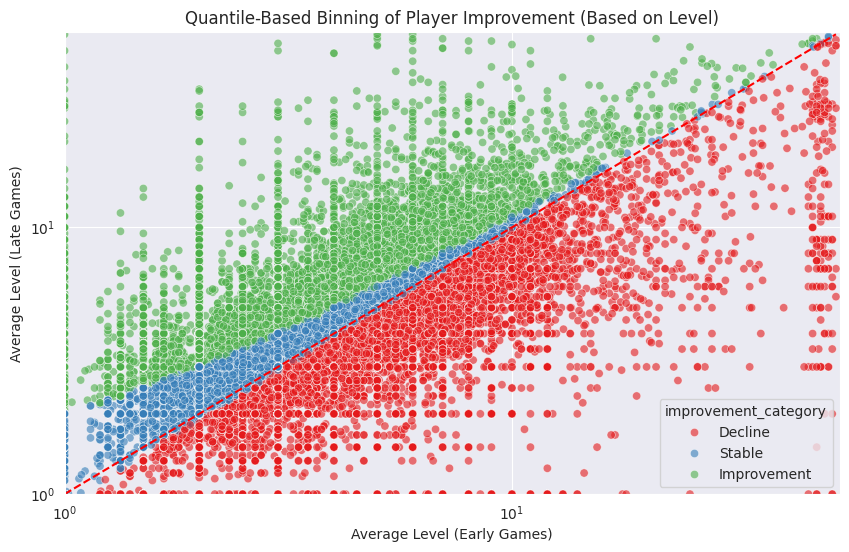

In [24]:
# Divide games into early and late halves based on levels reached
early_games = data.groupby('name').apply(lambda x: x.iloc[:len(x)//2]).reset_index(drop=True)
late_games = data.groupby('name').apply(lambda x: x.iloc[len(x)//2:]).reset_index(drop=True)

# Calculate average levels for early and late games
early_avg_level = early_games.groupby('name')['maxlvl'].mean()
late_avg_level = late_games.groupby('name')['maxlvl'].mean()

# Prepare data for clustering based on levels reached
improvement_data = pd.DataFrame({
    'early_avg_level': early_avg_level,
    'late_avg_level': late_avg_level
}).dropna()

# Optional: Remove negative or zero values if using log scale
improvement_data = improvement_data[(improvement_data['early_avg_level'] > 0) & (improvement_data['late_avg_level'] > 0)]

# Feature for clustering
improvement_data['improvement_diff'] = improvement_data['late_avg_level'] - improvement_data['early_avg_level']
improvement_data['improvement_ratio'] = improvement_data['late_avg_level'] / (improvement_data['early_avg_level'] + 1)  # +1 to avoid division by zero

# Quantile-based bins
bins = pd.qcut(improvement_data['improvement_diff'], q=3, labels=['Decline', 'Stable', 'Improvement'])
improvement_data['improvement_category'] = bins

# Visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(data=improvement_data, x='early_avg_level', y='late_avg_level', hue='improvement_category', palette='Set1', alpha=0.6)
plt.xlabel('Average Level (Early Games)')
plt.ylabel('Average Level (Late Games)')
plt.title('Quantile-Based Binning of Player Improvement (Based on Level)')

# Optional: Set limits for x and y axes for better visualization
plt.xlim(1, improvement_data['early_avg_level'].max() + 1)
plt.ylim(1, improvement_data['late_avg_level'].max() + 1)

plt.xscale('log')
plt.yscale('log')
plt.plot([1, max(improvement_data['late_avg_level'].max(), improvement_data['early_avg_level'].max())], 
         [1, max(improvement_data['late_avg_level'].max(), improvement_data['early_avg_level'].max())], 'r--')
plt.show()



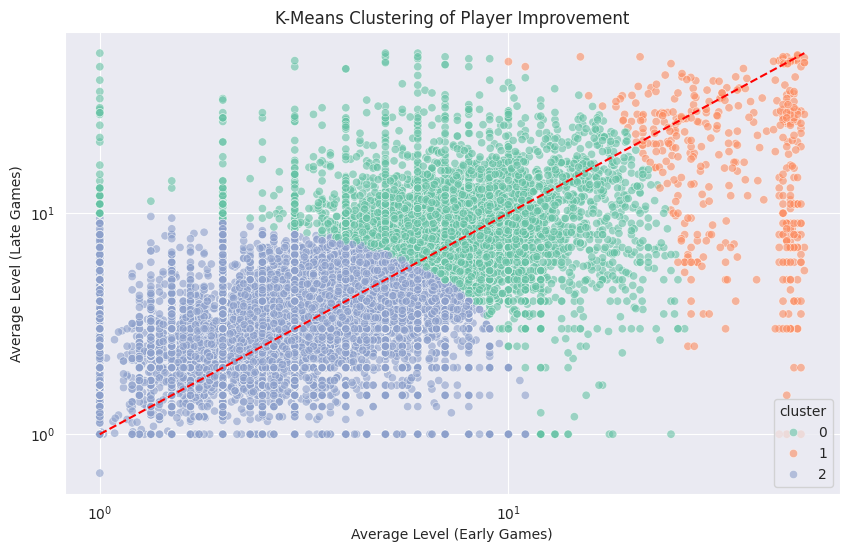

In [25]:
from sklearn.cluster import KMeans

# Choose an appropriate number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
improvement_data['cluster'] = kmeans.fit_predict(improvement_data[['early_avg_level', 'late_avg_level']])

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=improvement_data, x='early_avg_level', y='late_avg_level', hue='cluster', palette='Set2', alpha=0.6)
plt.xlabel('Average Level (Early Games)')
plt.ylabel('Average Level (Late Games)')
plt.title('K-Means Clustering of Player Improvement')
plt.xscale('log')
plt.yscale('log')
plt.plot([1, max(improvement_data['late_avg_level'].max(), improvement_data['early_avg_level'].max())], 
         [1, max(improvement_data['late_avg_level'].max(), improvement_data['early_avg_level'].max())], 'r--')
plt.show()

   cluster  early_avg_mean  early_avg_std  late_avg_mean  late_avg_std  \
0        0        7.837472       3.480610       9.143821      5.019590   
1        1       37.591849      11.367265      20.389442     13.039928   
2        2        3.051830       1.636055       3.419006      1.607613   

   improvement_diff_mean  improvement_diff_std  
0               1.306349              6.043288  
1             -17.202407             18.531495  
2               0.367176              1.744757  


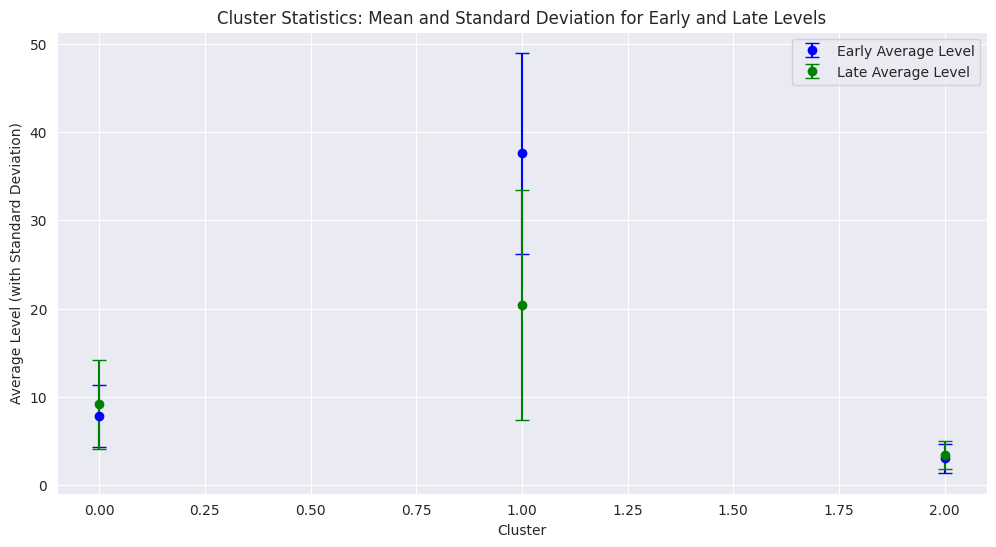

In [26]:
# Group the data by clusters and calculate statistics for early and late levels
cluster_stats = improvement_data.groupby('cluster').agg(
    early_avg_mean=('early_avg_level', 'mean'),
    early_avg_std=('early_avg_level', 'std'),
    late_avg_mean=('late_avg_level', 'mean'),
    late_avg_std=('late_avg_level', 'std'),
    improvement_diff_mean=('improvement_diff', 'mean'),
    improvement_diff_std=('improvement_diff', 'std')
).reset_index()

# Display the statistics
print(cluster_stats)

# Optional visualization for cluster-level statistics
plt.figure(figsize=(12, 6))

# Plot means with error bars (standard deviation)
plt.errorbar(
    cluster_stats['cluster'], 
    cluster_stats['early_avg_mean'], 
    yerr=cluster_stats['early_avg_std'], 
    fmt='o', capsize=5, label='Early Average Level', color='blue'
)
plt.errorbar(
    cluster_stats['cluster'], 
    cluster_stats['late_avg_mean'], 
    yerr=cluster_stats['late_avg_std'], 
    fmt='o', capsize=5, label='Late Average Level', color='green'
)

plt.xlabel('Cluster')
plt.ylabel('Average Level (with Standard Deviation)')
plt.title('Cluster Statistics: Mean and Standard Deviation for Early and Late Levels')
plt.legend()
plt.grid(True)
plt.show()

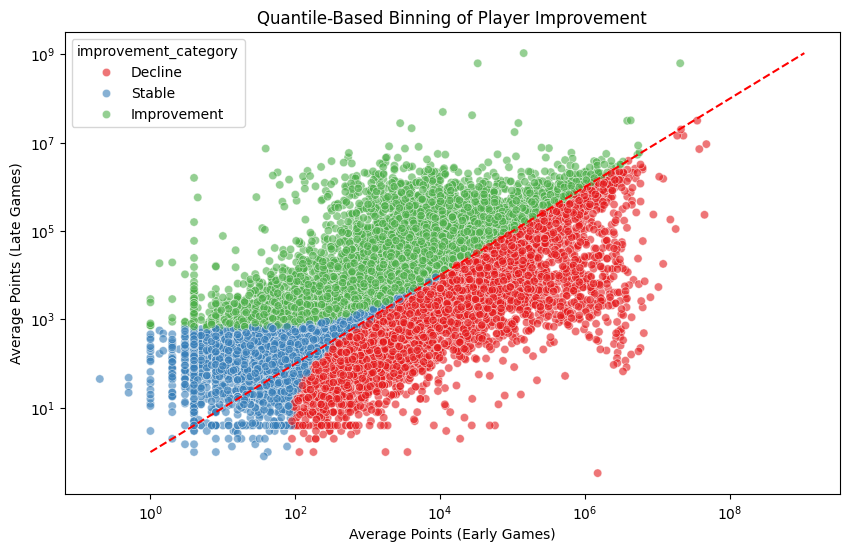

In [71]:
# prepare for clustering 
improvement_data = pd.DataFrame({
    'early_avg_points': early_avg_points,
    'late_avg_points': late_avg_points
}).dropna() 

# Feature for clustering
improvement_data['improvement_diff'] = improvement_data['late_avg_points'] - improvement_data['early_avg_points']
improvement_data['improvement_ratio'] = improvement_data['late_avg_points'] / (improvement_data['early_avg_points'] + 1)  # +1 to avoid division by zero

# Quantile-based bins
bins = pd.qcut(improvement_data['improvement_diff'], q=3, labels=['Decline', 'Stable', 'Improvement'])

improvement_data['improvement_category'] = bins

# Visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(data=improvement_data, x='early_avg_points', y='late_avg_points', hue='improvement_category', palette='Set1', alpha=0.6)
plt.xlabel('Average Points (Early Games)')
plt.ylabel('Average Points (Late Games)')
plt.title('Quantile-Based Binning of Player Improvement')
plt.xscale('log')
plt.yscale('log')
plt.plot([1, max(improvement_data['late_avg_points'].max(), improvement_data['early_avg_points'].max())], 
         [1, max(improvement_data['late_avg_points'].max(), improvement_data['early_avg_points'].max())], 'r--')
plt.show()

In [32]:
import pandas as pd
from scipy.stats import ttest_rel, ttest_ind
import numpy as np

# Assuming 'data' DataFrame contains columns 'name' (player), 'gameid', and 'maxlvl' (maximum level reached)

# Step 1: Divide games into early and late halves for each player
early_games = data.groupby('name').apply(lambda x: x.iloc[:len(x)//2]).reset_index(drop=True)
late_games = data.groupby('name').apply(lambda x: x.iloc[len(x)//2:]).reset_index(drop=True)

# Step 2: Calculate average levels for early and late games
early_avg_level = early_games.groupby('name')['maxlvl'].mean()
late_avg_level = late_games.groupby('name')['maxlvl'].mean()

# Step 3: Drop NaN values and align the indices (if necessary)
early_avg_level = early_avg_level.dropna()
late_avg_level = late_avg_level.dropna()

# Ensure we only consider players with both early and late games
common_indices = early_avg_level.index.intersection(late_avg_level.index)
early_avg_level = early_avg_level.loc[common_indices]
late_avg_level = late_avg_level.loc[common_indices]

# Step 4: Perform the T-Test
t_stat, p_value = ttest_rel(early_avg_level, late_avg_level)

# Print the results
print(f"T-statistic: {t_stat}, P-value: {p_value}")



/tmp/ipykernel_8381/2550995515.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  early_games = data.groupby('name').apply(lambda x: x.iloc[:len(x)//2]).reset_index(drop=True)
/tmp/ipykernel_8381/2550995515.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  late_games = data.groupby('name').apply(lambda x: x.iloc[len(x)//2:]).reset_index(drop=True)


T-statistic: -13.252083875710463, P-value: 5.653931494254562e-40


In [72]:
improvement_data = improvement_data.reset_index()

data_with_category = data.merge(improvement_data[['name', 'improvement_category']], on='name', how='inner')

improved_players = data_with_category[data_with_category['improvement_category'] == 'Improvement']

df = improved_players.sort_values(['name', 'starttime'])
df

,name,gameid,points,turns,maxlvl,starttime,endtime,death,improvement_category
0,Player0,3520378,0,52,1,1970-01-01 00:00:01.206144424,1970-01-01 00:00:01.206144460,killed by kicking a wall,Improvement
1,Player0,3520380,0,10,1,1970-01-01 00:00:01.206144463,1970-01-01 00:00:01.206144590,killed by kicking a wall,Improvement
2,Player0,3520795,161,308,3,1970-01-01 00:00:01.206223951,1970-01-01 00:00:01.206224061,quit,Improvement
3,Player0,3521208,250,8,6,1970-01-01 00:00:01.206271297,1970-01-01 00:00:01.206300939,killed by a priestess of Brigit,Improvement
4,Player0,3521210,3,1,1,1970-01-01 00:00:01.206300990,1970-01-01 00:00:01.206301044,escaped (in celestial disgrace),Improvement
...,...,...,...,...,...,...,...,...,...
1493791,Player9998,1902415,132,404,2,1970-01-01 00:00:01.599854080,1970-01-01 00:00:01.599854249,killed by a sewer rat,Improvement
1493792,Player9998,1902434,4507,4729,10,1970-01-01 00:00:01.600126884,1970-01-01 00:00:01.600216129,killed by a jaguar while reading a book,Improvement
1493793,Player9998,1902489,42,179,1,1970-01-01 00:00:01.601399676,1970-01-01 00:00:01.601399739,killed by a bear trap,Improvement
1493794,Player9998,1903284,2333,2913,8,1970-01-01 00:00:01.603063027,1970-01-01 00:00:01.603394301,killed by a killer bee,Improvement


In [73]:
# Create a binary column indicating if a game resulted in ascension
df['ascended'] = df['death'].apply(lambda x: 1 if x == 'ascended' else 0)  # Adjust 'death' column name if needed
player_ascension = df.groupby('name')['ascended'].max().reset_index()  # 1 if ascended in any game
total_players = player_ascension['name'].nunique()
non_ascended_players = player_ascension[player_ascension['ascended'] == 0]['name'].nunique()
percentage_non_ascended = (non_ascended_players / total_players) * 100

print(f"Percentage of players who did not ascend: {percentage_non_ascended:.2f}%")

Percentage of players who did not ascend: 81.10%


In [105]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# simple ascension measure with binary classification using logisitic regression 
df['ascended'] = df['death'].apply(lambda x: 1 if x == 'ascended' else 0)  # Adjust 'death' column name if different


player_stats = df.groupby('name').agg(
    avg_points=('points', 'mean'),
    max_level=('maxlvl', 'std'),
    total_games=('gameid', 'count')  # Assuming 'gameid' uniquely identifies a game
).reset_index()


player_ascension = df.groupby('name')['ascended'].max().reset_index()  # 1 if ascended in any game
player_stats = pd.merge(player_stats, player_ascension, on='name')


X = player_stats[['avg_points', 'max_level', 'total_games']]  # Features
y = player_stats['ascended']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9735941320293399
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1665
           1       0.92      0.94      0.93       380

    accuracy                           0.97      2045
   macro avg       0.95      0.96      0.96      2045
weighted avg       0.97      0.97      0.97      2045



In [75]:
def aggregate_features(data, n):
    player_data = []
    for player, group in data.groupby('name'):
        group = group.sort_values('starttime').head(n)
        
        # Days since last game
        total_games_played = len(group)
        days_since_first_game = (group['starttime'].max() - group['starttime'].min()).days
        games_per_month = total_games_played / ((days_since_first_game / 30) + 1)  # Avoid division by zero
        
        # Inter Session game time 
        time_between_games = group['starttime'].diff().dt.total_seconds() / (3600 * 24)  # Time in days
        avg_time_between_games = time_between_games.mean() if not time_between_games.isna().all() else 0
        std_time_between_games = time_between_games.std() if not time_between_games.isna().all() else 0
        
        # Performance Features - Over time 
        cumulative_points = group['points'].cumsum().iloc[-1] if len(group) > 0 else 0
        rolling_avg_points = group['points'].rolling(window=5, min_periods=1).mean().iloc[-1] if len(group) >= 5 else group['points'].mean()
        rate_of_improvement = group['points'].iloc[-1] - rolling_avg_points if len(group) > 0 else 0
        
        # Maximum level reached over time
        max_level_reached = group['maxlvl'].cummax().iloc[-1] if len(group) > 0 else 0
        

        # Kurtosis Points
        skew_points = group['points'].skew()
        kurtosis_points = group['points'].kurtosis()

        # Current Features
        features = {
            'name': player,
            'mean_turns': group['turns'].mean(),
            'max_turns': group['turns'].max(),
            'std_turns': group['turns'].std(),
            'mean_points': group['points'].mean(),
            'max_points': group['points'].max(),
            'std_points': group['points'].std(),
            'mean_maxlvl': group['maxlvl'].mean(),
            'max_maxlvl': group['maxlvl'].max(),
            'std_maxlvl': group['maxlvl'].std(),
            
            # target
            'ascended_next': int(group.iloc[-1]['ascended'] == 'ascended') if 'ascended' in group.columns else 0,
            
            # New features for persistence
            'total_games_played': total_games_played,
            'games_per_month': games_per_month,
            'avg_time_between_games': avg_time_between_games,
            'std_time_between_games': std_time_between_games,
            'cumulative_points': cumulative_points,
            'rolling_avg_points': rolling_avg_points,
            'rate_of_improvement': rate_of_improvement,
            'max_level_reached': max_level_reached,
            'skew_points': skew_points,
            'kurtosis_points': kurtosis_points
        }
        player_data.append(features)
    return pd.DataFrame(player_data)

# Example DataFrame with engineered features
n_games = 15 
persistence_df = aggregate_features(df, n=n_games)


In [76]:
from sklearn.linear_model import LinearRegression
import numpy as np

def calculate_trend_slope(group):
    if len(group) > 1:
        X = np.arange(len(group)).reshape(-1, 1)
        y = group['points'].values
        model = LinearRegression().fit(X, y)
        return model.coef_[0]  # Return the slope
    return 0


test_df = df.groupby('name').apply(calculate_trend_slope)
test_df = pd.DataFrame(test_df)
test_df

/tmp/ipykernel_7307/1052005867.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = df.groupby('name').apply(calculate_trend_slope)


,0
name,
Player0,35.142857
Player1,2.863018
Player10,139.243727
Player100,5.735244
Player10002,-969.744137
...,...
Player9975,840.208062
Player9985,55.566942
Player9986,128.095832


In [77]:
player_stats = pd.merge(player_stats, persistence_df, on='name')
# player_stats = pd.merge(player_stats, test_df, on='name')

In [32]:
# Save DataFrame
player_stats.to_csv('persist.csv', index=False)  


In [78]:
player_stats

,name,avg_points,max_level,total_games,ascended,mean_turns,max_turns,std_turns,mean_points,max_points,...,total_games_played,games_per_month,avg_time_between_games,std_time_between_games,cumulative_points,rolling_avg_points,rate_of_improvement,max_level_reached,skew_points,kurtosis_points
0,Player0,868.380952,7.289262,21,1,273.333333,1977,515.911076,1148.066667,9378,...,15,15.0,1.084843e-07,1.490584e-07,17221,3344.8,-2018.8,28,2.589443,6.104833
1,Player1,6520.143911,3.131439,542,0,1415.066667,4295,1062.228484,1803.333333,5750,...,15,15.0,2.839575e-10,5.249796e-10,27050,3587.2,-1149.2,11,1.194852,0.863563
2,Player10,29202.977941,6.192656,544,1,1896.200000,4517,1347.396972,1050.066667,4459,...,15,15.0,1.548454e-10,2.954710e-10,15751,1650.8,-1493.8,10,1.849403,2.744326
3,Player100,7164.450199,3.859576,502,0,1655.400000,3351,771.310091,1736.866667,4217,...,15,15.0,4.974777e-10,7.267413e-10,26053,2231.2,1985.8,8,0.762266,-0.206272
4,Player10002,270581.377778,15.337713,45,1,12184.933333,75110,20691.719612,387483.000000,2245661,...,15,15.0,4.603316e-08,1.137392e-07,5812245,910770.0,-771264.0,51,1.917587,2.260220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10216,Player9975,158158.736111,11.636589,144,1,2954.666667,11734,3764.256760,8632.533333,69535,...,15,15.0,2.990575e-10,3.851022e-10,129488,14877.4,-13537.4,16,2.974061,9.284829
10217,Player9985,8571.980488,3.764098,205,0,1266.600000,3883,1191.743309,2800.133333,20959,...,15,15.0,4.141493e-10,6.996798e-10,42002,4373.6,16585.4,9,2.758851,7.700529
10218,Player9986,3659.308824,3.731436,68,0,1123.466667,3488,1033.505399,689.066667,3344,...,15,15.0,5.888310e-11,1.144686e-10,10336,966.0,-60.0,10,2.132612,5.099376
10219,Player9994,15675.572202,3.474252,554,1,1199.533333,5507,1358.354354,614.000000,5552,...,15,15.0,2.113037e-10,4.897702e-10,9210,1321.2,4230.8,5,3.628274,13.584188


Correlations with the target 'ascended':
 ascended                  1.000000
max_level                 0.678521
max_maxlvl                0.529762
max_level_reached         0.529762
std_maxlvl                0.454462
mean_maxlvl               0.377742
max_turns                 0.372317
total_games_played        0.334138
games_per_month           0.334138
std_turns                 0.270255
mean_turns                0.262281
skew_points               0.253452
total_games               0.250020
kurtosis_points           0.238658
cumulative_points         0.091838
max_points                0.069795
avg_points                0.055462
rolling_avg_points        0.051739
std_points                0.050733
mean_points               0.045366
rate_of_improvement       0.036253
std_time_between_games    0.012819
avg_time_between_games   -0.024111
ascended_next                  NaN
Name: ascended, dtype: float64


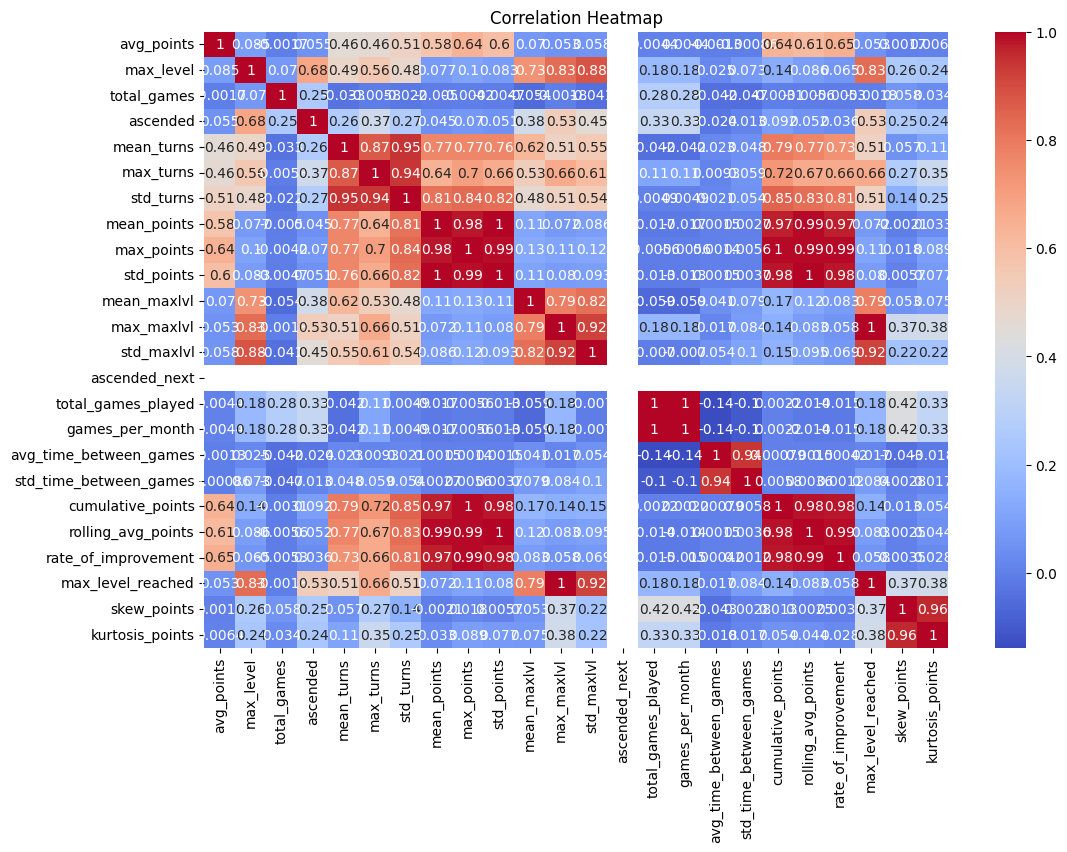

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Drop 
test = player_stats.drop(columns=['name'])
# Calculate correlation matrix
correlation_matrix = test.corr()

# Get correlations
target_correlation = correlation_matrix['ascended'].sort_values(ascending=False)

# Display correlations
print("Correlations with the target 'ascended':\n", target_correlation)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(test.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [104]:
X_1 = test.drop(columns=['ascended'])  # All other columns used as predictors
y_1 = test['ascended']  # Target variable
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

# Example: Using a Random Forest Classifier
persist_model = RandomForestClassifier(random_state=42)
persist_model.fit(X_train_1, y_train_1)

# Make predictions
y_pred = persist_model.predict(X_test)

# Evaluate model performance
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9726161369193154
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1665
           1       0.91      0.95      0.93       380

    accuracy                           0.97      2045
   macro avg       0.95      0.96      0.96      2045
weighted avg       0.97      0.97      0.97      2045



In [107]:
from sklearn.model_selection import cross_val_score
scores1 = cross_val_score(model, X, y, cv=5, scoring='accuracy') 
scores2 = cross_val_score(persist_model, X_1, y_1, cv=5, scoring='accuracy')

print("Baseline Mean Accuracy:", scores1.mean())
print("Persistence Model Mean Accuracy:", scores2.mean())

Baseline Mean Accuracy: 0.9690836319791003
Persistence Model Mean Accuracy: 0.9720191484169781


In [92]:
def calculate_lagged_features(group, lag=1):
    group = group.sort_values('starttime')
    group['lagged_points'] = group['points'].shift(lag)
    return group['lagged_points'].iloc[-1] if len(group) > lag else np.nan

df_1 = pd.DataFrame(df.groupby('name').apply(calculate_lagged_features)) 

/tmp/ipykernel_7307/3645949215.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_1 = pd.DataFrame(df.groupby('name').apply(calculate_lagged_features))


In [95]:
df_1.columns = ['lagged_features']
df_1

,lagged_features
name,
Player0,106.0
Player1,164.0
Player10,1228.0
Player100,6012.0
Player10002,741.0
...,...
Player9975,12.0
Player9985,56.0
Player9986,361.0


In [97]:
df_1 = pd.merge(player_stats, df_1, on='name')
df_1

,name,avg_points_x,max_level_x,total_games_x,ascended_x,mean_turns_x,max_turns_x,std_turns_x,mean_points_x,max_points_x,...,games_per_month_y,avg_time_between_games_y,std_time_between_games_y,cumulative_points_y,rolling_avg_points_y,rate_of_improvement_y,max_level_reached_y,skew_points_y,kurtosis_points_y,lagged_features
0,Player0,868.380952,7.289262,21,1,273.333333,1977,515.911076,1148.066667,9378,...,15.0,1.084843e-07,1.490584e-07,17221,3344.8,-2018.8,28,2.589443,6.104833,106.0
1,Player1,6520.143911,3.131439,542,0,1415.066667,4295,1062.228484,1803.333333,5750,...,15.0,2.839575e-10,5.249796e-10,27050,3587.2,-1149.2,11,1.194852,0.863563,164.0
2,Player10,29202.977941,6.192656,544,1,1896.200000,4517,1347.396972,1050.066667,4459,...,15.0,1.548454e-10,2.954710e-10,15751,1650.8,-1493.8,10,1.849403,2.744326,1228.0
3,Player100,7164.450199,3.859576,502,0,1655.400000,3351,771.310091,1736.866667,4217,...,15.0,4.974777e-10,7.267413e-10,26053,2231.2,1985.8,8,0.762266,-0.206272,6012.0
4,Player10002,270581.377778,15.337713,45,1,12184.933333,75110,20691.719612,387483.000000,2245661,...,15.0,4.603316e-08,1.137392e-07,5812245,910770.0,-771264.0,51,1.917587,2.260220,741.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10216,Player9975,158158.736111,11.636589,144,1,2954.666667,11734,3764.256760,8632.533333,69535,...,15.0,2.990575e-10,3.851022e-10,129488,14877.4,-13537.4,16,2.974061,9.284829,12.0
10217,Player9985,8571.980488,3.764098,205,0,1266.600000,3883,1191.743309,2800.133333,20959,...,15.0,4.141493e-10,6.996798e-10,42002,4373.6,16585.4,9,2.758851,7.700529,56.0
10218,Player9986,3659.308824,3.731436,68,0,1123.466667,3488,1033.505399,689.066667,3344,...,15.0,5.888310e-11,1.144686e-10,10336,966.0,-60.0,10,2.132612,5.099376,361.0
10219,Player9994,15675.572202,3.474252,554,1,1199.533333,5507,1358.354354,614.000000,5552,...,15.0,2.113037e-10,4.897702e-10,9210,1321.2,4230.8,5,3.628274,13.584188,90.0


In [99]:
X = player_stats['lagged_features'].astype(float) # Features
y = player_stats['ascended']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier()
model.fit(X_train, y_train)

# Step 4: Evaluate the Model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


KeyError: 'lagged_features'